In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

In [80]:
incomes = pd.read_csv('income_evaluation.csv')
incomes.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [79]:
incomes.describe().applymap(lambda x: f"{x:0.1f}")

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.0,32561.0,32561.0,32561.0,32561.0,32561.0
mean,38.6,189778.4,10.1,1077.6,87.3,40.4
std,13.6,105550.0,2.6,7385.3,403.0,12.3
min,17.0,12285.0,1.0,0.0,0.0,1.0
25%,28.0,117827.0,9.0,0.0,0.0,40.0
50%,37.0,178356.0,10.0,0.0,0.0,40.0
75%,48.0,237051.0,12.0,0.0,0.0,45.0
max,90.0,1484705.0,16.0,99999.0,4356.0,99.0


In [ ]:
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

plt.figure(figsize=(12, 6))

for i, column in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), len(numeric_cols)//2, i)
    sns.boxplot(x=incomes[column])

plt.suptitle('Wykresy pudełkowe dla zmiennych liczbowych')
plt.tight_layout()
plt.show()

In [89]:
null_counts = pd.DataFrame(incomes[incomes.select_dtypes('number').columns].isna().sum(), columns=['Null Counts'])
null_counts

# plt.bar(null_counts.index, null_counts['Null Counts'], color='dimgray')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Columns')
# plt.ylabel('Brakujące wartości')
# plt.title('Brakujące wartości w zbiorze danych')
# for i, value in enumerate(null_counts['Null Counts']):
#     plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)
# plt.show()

,Null Counts
age,0
fnlwgt,0
hours-per-week,0
additional_money,0


In [83]:
incomes = incomes.rename(columns=lambda x: x.strip())
categories = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']
incomes[categories] = incomes[categories].astype("category")
incomes = incomes.applymap(lambda x: x.strip() if not isinstance(x, int) else x)

In [84]:
for column in categories:
    print(column, set(incomes[column]))

workclass {'?', 'Private', 'Self-emp-inc', 'Without-pay', 'Local-gov', 'Self-emp-not-inc', 'Never-worked', 'State-gov', 'Federal-gov'}
education {'Assoc-acdm', 'Masters', '1st-4th', 'Preschool', 'Bachelors', '7th-8th', '10th', 'Assoc-voc', 'HS-grad', '11th', 'Doctorate', '12th', 'Some-college', '5th-6th', '9th', 'Prof-school'}
marital-status {'Never-married', 'Divorced', 'Married-AF-spouse', 'Married-spouse-absent', 'Widowed', 'Married-civ-spouse', 'Separated'}
occupation {'Other-service', '?', 'Adm-clerical', 'Exec-managerial', 'Machine-op-inspct', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv', 'Transport-moving', 'Handlers-cleaners', 'Tech-support', 'Farming-fishing', 'Sales', 'Prof-specialty', 'Craft-repair'}
relationship {'Husband', 'Unmarried', 'Wife', 'Own-child', 'Other-relative', 'Not-in-family'}
race {'White', 'Black', 'Amer-Indian-Eskimo', 'Asian-Pac-Islander', 'Other'}
sex {'Male', 'Female'}
native-country {'Jamaica', 'Germany', 'Nicaragua', 'United-States', 'China', 

In [85]:
for column in ['workclass', 'occupation', 'native-country']:
    incomes[column].replace("?", np.NaN, inplace=True)
    incomes[column] = incomes[column].fillna(incomes[column].mode()[0])

In [86]:
incomes['additional_money'] = incomes['capital-gain'] - incomes['capital-loss']
incomes = incomes.drop(columns=['capital-gain', 'capital-loss', 'education-num', 'relationship'], axis=1)
incomes.head()

,age,workclass,fnlwgt,education,marital-status,occupation,race,sex,hours-per-week,native-country,income,additional_money
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,White,Male,40,United-States,<=50K,2174
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,White,Male,40,United-States,<=50K,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,40,Cuba,<=50K,0


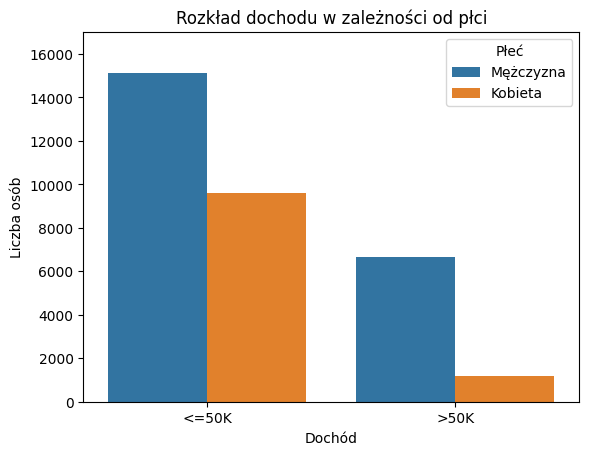

In [88]:
ctplot = sns.countplot(data=incomes, x='income', hue='sex')

ctplot.set_xlabel('Dochód')
ctplot.set_ylabel('Liczba osób')
ctplot.set_title('Rozkład dochodu w zależności od płci')
ctplot.set_ylim(0, 17000)

ctplot.legend(title='Płeć', labels=['Mężczyzna', 'Kobieta'])

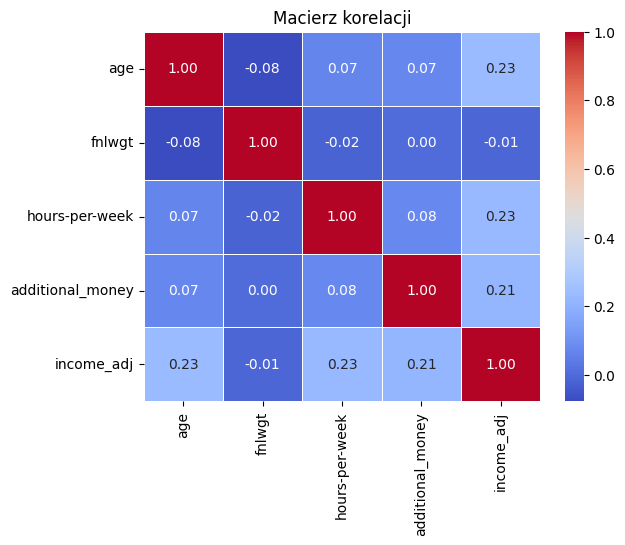

In [93]:
def adjust_income(income: str):
  if income == '<=50K':
    return 0
  elif income == '>50K':
    return 1
  else:
      return 0

incomes['income_adj'] = incomes['income'].apply(adjust_income)
numeric_cols = incomes.select_dtypes('number').columns
correlation_matrix = incomes[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Macierz korelacji')
incomes.drop('income_adj', axis=1, inplace=True)

In [94]:
def change_education(education: str):
    if education in ["10th", "11th", "12th", "1st-4th", "5th-6th", "7th-8th", "9th", "Preschool"]:
        return "Primary"
    elif education in ["Bachelors", "Some-college"]:
        return "Bachelors"
    elif education in ["Assoc-acdm", "Assoc-voc"]:
        return "Associate"
    else:
        return education
incomes['education'] = incomes['education'].apply(change_education)
set(incomes['education'])

{'Associate',
 'Bachelors',
 'Doctorate',
 'HS-grad',
 'Masters',
 'Primary',
 'Prof-school'}

In [96]:
training_cols = ['age', 'workclass', 'education', 'race', 'sex', 'hours-per-week', 'native-country', 'additional_money', 'income', 'fnlwgt']
training_incomes = incomes[training_cols]
categorical_cols = ['workclass', 'race', 'sex', 'native-country', 'education']
numeric = ['age', 'hours-per-week', 'additional_money', 'fnlwgt']

encoder = OneHotEncoder(sparse=False)
encoded_cols = pd.DataFrame(encoder.fit_transform(training_incomes[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))
training_incomes = pd.concat([training_incomes.drop(columns=categorical_cols), encoded_cols], axis=1)

scaler = RobustScaler()
# scaler = StandardScaler()
# scaler = MinMaxScaler()

training_incomes[numeric] = scaler.fit_transform(training_incomes[numeric])

training_incomes.columns
X = training_incomes.drop('income', axis=1)
y = incomes['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [97]:
rand_for = RandomForestClassifier(n_estimators=500, random_state=42, max_leaf_nodes=160)

rand_for.fit(X_train, y_train)
rand_for.score(X_test, y_test)

0.841911313106498

<ipython-input-98-0e09c1c98edf>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


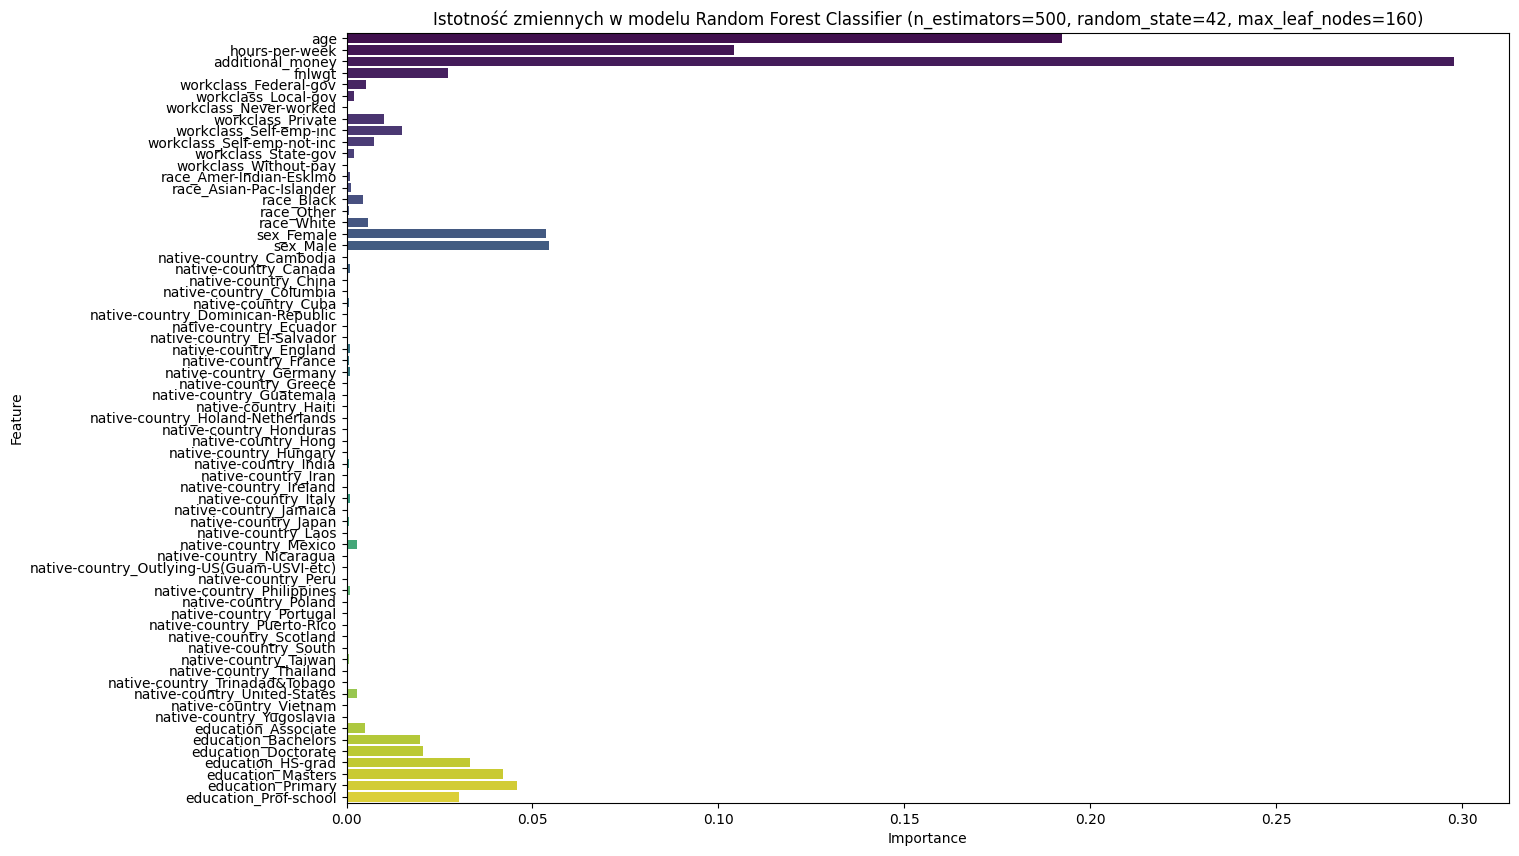

In [98]:
feature_importances = rand_for.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values("Importance", ascending=False)
feature_importance_df['Importance'].map(lambda x: f"{x:0.1f}")

# Plot the feature importances
plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Istotność zmiennych w modelu Random Forest Classifier (n_estimators=500, random_state=42, max_leaf_nodes=160)')
plt.show()

In [99]:
y_pred = rand_for.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[6012,  202],
       [1085,  842]])

In [100]:
precision_score(y_test, y_pred)
# recall_score(y_test, y_pred)
# f1_score(y_test, y_pred)

ValueError: pos_label=1 is not a valid label. It should be one of ['<=50K', '>50K']